<a href="https://colab.research.google.com/github/rakshit2020/Pedestrian-Intention-Detection/blob/main/vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils


Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('/content/drive/MyDrive/banglorefinal/annotations3')))
print(len(os.listdir('/content/drive/MyDrive/banglorefinal/images3')))






1001
1001


In [ ]:
!mkdir test_images1
!mkdir test_annotations1

In [ ]:
random.seed(1234)
idx = random.sample(range(1001),200)

for img in np.array(sorted(os.listdir('/content/drive/MyDrive/banglorefinal/images3')))[idx]:
    shutil.copy('/content/drive/MyDrive/banglorefinal/images3/'+img, '/content/test_images1/'+img)

for annot in np.array(sorted(os.listdir('/content/drive/MyDrive/banglorefinal/annotations3')))[idx]:
    shutil.copy('/content/drive/MyDrive/banglorefinal/annotations3/'+annot, '/content/test_annotations1/'+annot)

print(len(os.listdir('/content/drive/MyDrive/banglorefinal/annotations3')))
print(len(os.listdir('/content/drive/MyDrive/banglorefinal/images3')))
print(len(os.listdir('/content/test_annotations1/')))
print(len(os.listdir('/content/test_images1/')))

1001
1001
200
200


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 0

def generate_label(obj):

    if obj.find('name').text == "motorcycle":

        return 1 + adjust_label

    elif obj.find('name').text == "car":

        return 2 + adjust_label

    elif obj.find('name').text == "bus":

        return 3 + adjust_label




   

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='black',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')

        elif annotation['labels'][idx] == 3 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='white',facecolor='none')
        
     
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class AV(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("/content/test_annotations1/", file_label)
        else:
            label_path = os.path.join("/content/drive/MyDrive/banglorefinal/annotations3/", file_label)
            
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = AV(data_transform, '/content/drive/MyDrive/banglorefinal/images3/')
test_dataset = AV(data_transform, '/content/test_images1/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
def get_model_instance(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model



In [ ]:
model = get_model_instance(5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())   
        # acc=(model.argmax(dim=1)==label).float().mean()
        # epoch_accuracy+=acc/len(train_loader)


        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')
    torch.save(model.state_dict(),f'model_{num_epochs}.pt')

----------------------train start--------------------------
epoch : 1, Loss : 155.24732971191406, time : 314.00374817848206
epoch : 2, Loss : 124.5740737915039, time : 327.16231536865234
epoch : 3, Loss : 113.00453186035156, time : 327.552827835083
epoch : 4, Loss : 106.24506378173828, time : 327.7138533592224
epoch : 5, Loss : 102.50720977783203, time : 328.0756995677948
epoch : 6, Loss : 102.62792205810547, time : 327.91952180862427
epoch : 7, Loss : 98.97459411621094, time : 327.8020303249359
epoch : 8, Loss : 93.49342346191406, time : 328.0732421875
epoch : 9, Loss : 89.35078430175781, time : 328.0432593822479
epoch : 10, Loss : 87.62686920166016, time : 328.02147579193115


In [ ]:
model.load_state_dict(torch.load('/content/model_1.pt'))

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list].detach().cpu().numpy()
        preds[id]['labels'] = preds[id]['labels'][idx_list].detach().cpu().numpy()
        preds[id]['scores'] = preds[id]['scores'][idx_list].detach().cpu().numpy()

    return preds

In [ ]:
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': array([[1310.9476 ,  621.18024, 1371.4758 ,  722.88574],
       [ 809.9535 ,  642.8113 ,  865.31555,  744.16296],
       [ 963.90717,  521.7045 , 1336.9082 ,  950.0737 ],
       [ 882.06696,  604.53   ,  928.63763,  678.43896],
       [ 842.58716,  628.89954,  905.8839 ,  700.233  ],
       [ 523.26373,  651.28644,  690.97363, 1008.84924],
       [ 971.492  ,  598.3202 ,  999.76996,  650.1892 ],
       [ 871.3945 ,  597.56256,  898.4093 ,  640.9511 ],
       [ 858.30597,  612.91846,  923.5831 ,  690.58057],
       [ 842.17267,  641.5593 ,  878.4535 ,  719.0786 ],
       [ 968.90515,  595.3743 ,  990.4742 ,  640.6153 ],
       [ 989.6293 ,  578.6223 , 1016.71246,  599.27136],
       [ 965.52216,  604.78735,  996.40283,  679.29816],
       [ 827.459  ,  630.6306 ,  886.973  ,  727.5562 ]], dtype=float32), 'labels': array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]), 'scores': array([0.9954497 , 0.99077904, 0.9894783 , 0.9837661 , 0.9833723 ,
       0.98302966, 0.87007445, 0.837

Target :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])


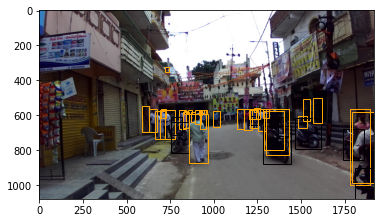

Prediction :  [1 1 1 1 1 1 1 1]


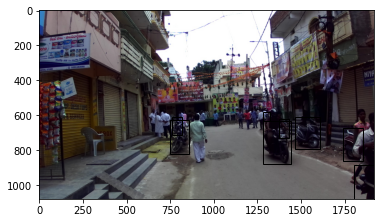

In [ ]:

_idx = 3
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])


In [ ]:
def make_prediction1(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction1(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)

print(f'precision : {precision}')
print(f'recall: {recall}')
print(f'f1 : {f1}')
print(f'mAP : {mAP}')
print(f'AP : {AP}')

precision : tensor([0.0000, 0.7140, 0.8994, 0.9725], dtype=torch.float64)
recall: tensor([0.0000, 0.8652, 0.8725, 0.6424], dtype=torch.float64)
f1 : tensor([0.0000, 0.7823, 0.8857, 0.7737], dtype=torch.float64)
mAP : 0.582666176130231
AP : tensor([0.0000, 0.8291, 0.8631, 0.6385], dtype=torch.float64)
